# TheMedNet Data Challenge: Lukasz Przychodzien

The goal is to identify if two questions are duplicates are not. Please submit a GitHub repository which includes a python notebook. Report your performance on the test set which is included. 
https://www.kaggle.com/c/quora-question-pairs/overview 

For each ID in the test set, you must predict the probability that the questions are duplicates (a number between 0 and 1). The file should contain a header and have the following format:

In [ ]:
test_id,is_duplicate
0,0.5
1,0.4
2,0.9
etc.

The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

## Data fields
id - the id of a training set question pair

qid1, qid2 - unique ids of each question (only available in train.csv)

question1, question2 - the full text of each question

is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

## Evaluation
Submissions are evaluated on the log loss between the predicted values and the ground truth. Therefore, we are stiving for a lower log-loss value. 

https://www.kaggle.com/dansbecker/what-is-log-loss

https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb 

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lprzy\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [2]:
os.chdir('C:/Users/lprzy/Documents/takehome/quora-question-pairs')

In [3]:
df_train = pd.read_csv('train.csv')

In [4]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Exploratory Analysis of Training Data

Note: Add visualizations

In [92]:
#Total number of question pairs for training
len(df_train.id)

404290

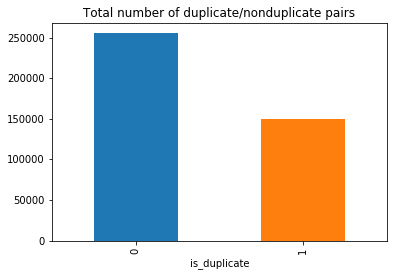

In [93]:
df_train.groupby("is_duplicate")['id'].count().plot.bar(title='Total number of duplicate/nonduplicate pairs')

In [94]:
#Percent of pairs that are duplicates
len(df_train[df_train.is_duplicate==1])/len(df_train.id)

0.369197853026293

In [4]:
#identifying any null values
df_train.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [4]:
#Replace the empty questions with the word empty
df_train = df_train.fillna('empty')

In [7]:
#Total number of unique question
allqid = list(df_train.qid1)+list(df_train.qid2)
unique_elem, counts_elem = np.unique(allqid, return_counts=True)
len(unique_elem)

537933

In [98]:
#Total number of duplicate questions
np.sum(counts_elem > 1)

111780

In [99]:
#Percent of duplicate questions of total questions
np.sum(counts_elem > 1)/len(counts_elem)

0.20779539459375052

In [100]:
#Maximum number of times one question appears in the dataset
counts_elem.max()

157

In [5]:
allq = pd.Series(df_train.question1.tolist() + df_train.question2.tolist()).astype(str)

In [102]:
#Total number of questions
len(allq)

808580

In [103]:
#Maximum number of characters found in a question
allq.apply(len).max()

1169

In [104]:
#Maxium number of words found in a question
allq.apply(lambda x: len(x.split(' '))).max()

237

In [105]:
#Number of unqiue words in our corpus 
allq.apply(lambda x: len(x.split(' '))).nunique()

102

## TF-IDF

### Tokenize questions

In [6]:
allq = allq.tolist()

We process the text by both stemming and lemmatization to see which brings the words to their root or canonical forms, respectively. 

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [8]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
tokenizer = CountVectorizer().build_tokenizer()

def lemmed_words(doc):
    return (lemmatizer.lemmatize(w) for w in tokenizer(doc))

In [9]:
#Create our count vectorizers for word standardization
cvl = CountVectorizer(stop_words='english', tokenizer=lemmed_words)
cvs = CountVectorizer(stop_words='english', analyzer=stemmed_words)

In [12]:
#learn the vocabulary of the stemmed questions
cvs.fit(allq)

CountVectorizer(analyzer=<function stemmed_words at 0x000001C78E10C378>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [13]:
#learn the vocabulary of the lemmed questions
cvl.fit(allq)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function lemmed_words at 0x000001C78E10C840>,
        vocabulary=None)

In [15]:
#Entire vocabulary and integer count of the number of times 
#each word appeared in all the questions (tokenized)

#Number of words on our vocabulary 
print(len(cvl.vocabulary_))
print(len(cvs.vocabulary_))

78368
65362


In [16]:
#encode the questions based on the vocabulary 
doc_cvs_matrix = cvs.transform(allq)
doc_cvl_matrix = cvl.transform(allq)

In [17]:
#The shape of our matrix which is the questions are encoded into seperate words
print(doc_cvs_matrix.shape)
print(doc_cvl_matrix.shape)

(808580, 65362)
(808580, 78368)


## Term Frequencies Transformation (Stemming)

In [82]:
#Since we used CountVectorizer, we just use the Tf-IDF transformer 
from sklearn.feature_extraction.text import TfidfTransformer

In [83]:
#Create tf-idf transformer 
tf_transformer = TfidfTransformer()
tf_transformer.fit(doc_cvs_matrix)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [84]:
#Transform each question into a count matrix
cv_q1 = cvs.transform(df_train.question1)
cv_q2 = cvs.transform(df_train.question2)

In [85]:
#Transform each set of questions into a tf-idf representation
df_train_tfidf_q1 = tf_transformer.transform(cv_q1)
df_train_tfidf_q2 = tf_transformer.transform(cv_q1)

In [86]:
df_train_tfidf_q1.shape

(404290, 65362)

In [87]:
#Define our X and y values for statistical modeling
#X is the absolute difference between each pair of questions
#y is the score we are trying to predict, whether duplicate or not

X = abs(df_train_tfidf_q1 - df_train_tfidf_q2)
y = df_train['is_duplicate']

## Machine Learning Models (stemming)

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score

In [89]:
#Split the training data into test and train data for our models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [26]:
#Ensuring that the train data is split between dupliate/nonduplicate
y_train[y_train==1].count()/len(y_train)

0.36855439694985564

In [27]:
#Ensuring that the test data is split between dupliate/nonduplicate
y_test[y_test==1].count()/len(y_test)

0.37069925053798014

### Logistic Regression

In [28]:
lr = LogisticRegression()

In [29]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
#The predict_proba function returns probability of 0 and 1, respectively. 
#We need to only select the probability of 1 (same question)
pred_lr = lr.predict_proba(X_test)[:,1]

In [31]:
logloss_lr = log_loss(y_test, pred_lr)

In [32]:
logloss_lr

0.6593365992323104

In [33]:
y_pred_lr = lr.predict(X_test)

In [34]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
(tn, fp, fn, tp)

(76326, 0, 44961, 0)

### Random Forest

In [35]:
rf = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 2, max_features = 6, min_samples_split = 2, n_jobs = -1)

In [36]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
pred_rf = rf.predict_proba(X_test)[:,1]
logloss_rf = log_loss(y_test, pred_rf)

In [38]:
logloss_rf

0.6593365740708749

In [39]:
y_pred_rf = rf.predict(X_test)

In [40]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
(tn, fp, fn, tp)

(76326, 0, 44961, 0)

### XGBoost

In [90]:
from sklearn.ensemble import GradientBoostingClassifier

xgb = GradientBoostingClassifier()
xgb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [91]:
pred_xgb = xgb.predict_proba(X_test)[:,1]
logloss_xgb = log_loss(y_test, pred_xgb)

In [92]:
logloss_xgb

0.6593098355618345

In [93]:
y_pred_xgb = xgb.predict(X_test)

In [94]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_xgb).ravel()
(tn, fp, fn, tp)

(76332, 0, 44955, 0)

## Term Frequencies Transformation (Lemmatization)

In [72]:
#Create tf-idf transformer 
tf_transformer = TfidfTransformer()
tf_transformer.fit(doc_cvl_matrix)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [73]:
#Transform each question into a count matrix
cv_q1 = cvl.transform(df_train.question1)
cv_q2 = cvl.transform(df_train.question2)

In [74]:
#Transform each set of questions into a tf-idf representation
df_train_tfidf_q1 = tf_transformer.transform(cv_q1)
df_train_tfidf_q2 = tf_transformer.transform(cv_q1)

In [75]:
df_train_tfidf_q1.shape

(404290, 78368)

In [76]:
#Define our X and y values for statistical modeling
#X is the absolute difference between each pair of questions
#y is the score we are trying to predict, whether duplicate or not

X = abs(df_train_tfidf_q1 - df_train_tfidf_q2)
y = df_train['is_duplicate']

## Machine Learning Models (Lemmatization)

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score

In [47]:
#Split the training data into test and train data for our models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [48]:
#Ensuring that the train data is split between dupliate/nonduplicate
y_train[y_train==1].count()/len(y_train)

0.3699183400882676

In [49]:
#Ensuring that the test data is split between dupliate/nonduplicate
y_test[y_test==1].count()/len(y_test)

0.3675167165483523

### Logistic Regression

In [50]:
lr = LogisticRegression()

In [51]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
#The predict_proba function returns probability of 0 and 1, respectively. 
#We need to only select the probability of 1 (same question)
pred_lr = lr.predict_proba(X_test)[:,1]

In [53]:
logloss_lr = log_loss(y_test, pred_lr)

In [54]:
logloss_lr

0.6576332453387124

In [55]:
y_pred_lr = lr.predict(X_test)

In [56]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
(tn, fp, fn, tp)

(76712, 0, 44575, 0)

### Random Forest

In [57]:
rf = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 2, max_features = 6, min_samples_split = 2, n_jobs = -1)

In [58]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [59]:
pred_rf = rf.predict_proba(X_test)[:,1]
logloss_rf = log_loss(y_test, pred_rf)

In [60]:
logloss_rf

0.6576335419401186

In [61]:
y_pred_rf = rf.predict(X_test)

In [62]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
(tn, fp, fn, tp)

(76712, 0, 44575, 0)

### XGBoost

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

xgb = GradientBoostingClassifier()
xgb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [66]:
pred_xgb = xgb.predict_proba(X_test)[:,1]
logloss_xgb = log_loss(y_test, pred_xgb)

In [67]:
logloss_xgb

0.6576331797943757

In [70]:
y_pred_xgb = xgb.predict(X_test)

In [71]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_xgb).ravel()
(tn, fp, fn, tp)

(76712, 0, 44575, 0)

## Stemming and Lemmatization Results

Stemming allowed us to reach a log loss of 0.6593
Lemmatization allowed us to reach a log loss of 0.6576

## Cosine Similarity

In [52]:
#Returns the cosine of the angle between the two vectors
from sklearn.metrics.pairwise import cosine_similarity
Xcs = cosine_similarity(df_train_tfidf_q1,df_train_tfidf_q2)

MemoryError: 